In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def determine_site_dist(map, depth, freq, info, depth_thres = 1):
    """For all sites, determine if they are fixed or polymorphic"""

    Dist = []
    for i in range(info.shape[0]):
        # Add samples IDs as map header and match samples
        # in map with samples in depth

        # Create site data frame
        site = map.copy()
        site['depth'] = depth.loc[ depth.index[i], map.index ]
        site['freq'] = freq.loc[ freq.index[i], map.index ]

        # Remove samples without information for site
        site = site[site.depth >= depth_thres]

        # Determine if it is polymorphic or fixed
        site_crosstab = pd.crosstab(site.freq >= 0.5, site.Group)
        if site_crosstab.shape == (2,2):
            if (np.matrix(site_crosstab).diagonal() == [0,0]).all() or (np.fliplr(np.matrix(site_crosstab)).diagonal() == [0, 0]).all():
                mutation_type = 'fixed'
            else:
                mutation_type = 'polymorphic'
        else:
            mutation_type = np.nan

        Dist.append(mutation_type)
    
    return(Dist)

In [3]:
def determine_mutation_effect(r):
    """Mini function for apply, takes a series and checks if the mutation
    is synonymous (s) or non-synonymopus (n)"""
    
    ii = r.loc[['count_a', 'count_c', 'count_g', 'count_t']] > 0
    aa = np.array(r.amino_acids.split(sep=','))

    if all(aa[ii][0] == aa[ii]):
        effect = 's'
    else:
        effect = 'n'

    return effect

In [4]:
def mktest_fisher_exact(g):
    """Per perform the fisher's exact test on a gene MK 
    contingency table."""
    
    tab = np.array([[g.Dn,g.Pn],[g.Ds,g.Ps]])
    oddsratio, pval = stats.fisher_exact(tab, alternative='two-sided')
    # oddsratio, pval = stats.fisher_exact(tab, alternative='greater')
    
    return pval

In [5]:
map_file = "/home/sur/micropopgen/data/test_data/midas/map.txt"
depth_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_depth.txt"
info_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_info.txt"
freqs_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_freq.txt"
groups = ['Buccal mucosa', 'Tongue dorsum']
depth_thres = 1
cov_thres = 3

In [6]:
# Read map file and select groups
map = pd.read_csv(map_file, sep="\t")
map.index = map.ID
map = map.loc[map.Group.isin(groups),:].copy()

In [7]:
# Read data
info = pd.read_csv(info_file, sep="\t")
depth = pd.read_csv(depth_file, sep="\t")
freq = pd.read_csv(freqs_file, sep="\t")

# Remove non gene sites
ii = ~info.gene_id.isnull()
info = info.loc[ii, :]
depth = depth.loc[ii, :]
freq = freq.loc[ii, :]

# Remove site_id columns
depth = depth.drop(axis=1, labels='site_id')
freq = freq.drop(axis=1, labels='site_id')

# Get list of genes
gene_ids = info.gene_id.unique()

# subset for tests
# info = info.head(5000)
# depth = depth.head(5000)
# freq = freq.head(5000)

# Determine effect of sites (this is constant and indepentent of samples)
info['Effect'] = info.apply(determine_mutation_effect, axis=1)

In [8]:
# Check that sample names match between freq and depth
if not all(freq.columns == depth.columns):
    raise ValueError("Columns don't match between freq and depth files")

    
# Remove samples from other groups
ci = depth.columns.isin(map.ID)
depth = depth.loc[:, ci]
freq = freq.loc[:, ci]

# Reorder map
map = map.loc[depth.columns,:]

# Calculate coverage in sites
map['coverage'] = depth.mean(axis=0)

# Remove samples below coverage
ci = map.coverage >= cov_thres
map = map.loc[ci, :]
depth = depth[map.index]
freq = freq[map.index]

if not all(map.index == depth.columns):
    raise ValueError("Samples in map and depth don't match")

# Determine type of mutation
info['Type'] = determine_site_dist(map=map, depth=depth, freq=freq, info=info, depth_thres=depth_thres)
info.head()

,site_id,ref_id,ref_pos,ref_allele,major_allele,minor_allele,count_samples,count_a,count_c,count_g,count_t,locus_type,gene_id,snp_type,site_type,amino_acids,Effect,Type
12,419,CM002128,419,A,A,T,42,440,0,0,17,CDS,1316408.3.peg.1,bi,3D,"I,M,I,I",s,polymorphic
13,425,CM002128,425,G,G,T,42,1,0,428,9,CDS,1316408.3.peg.1,bi,3D,"I,M,I,I",s,NaN
14,437,CM002128,437,A,A,T,41,353,0,0,17,CDS,1316408.3.peg.1,bi,4D,"S,S,S,S",s,polymorphic
15,443,CM002128,443,A,A,G,38,275,0,37,0,CDS,1316408.3.peg.1,bi,4D,"P,P,P,P",s,polymorphic
16,453,CM002128,453,T,T,C,32,0,6,0,259,CDS,1316408.3.peg.1,bi,1D,"I,S,T,N",n,NaN


In [9]:
# Calculate MK contingency table per gene
Genes = pd.DataFrame(columns=['Gene', 'Dn', 'Ds', 'Pn', 'Ps'])
for g in info.gene_id.unique():
    dat = info.loc[info.gene_id == g,:].copy()
    tab = pd.crosstab(dat.Effect, dat.Type, rownames=['Effect'], colnames=['Type'])
    tab = tab.reindex(index=pd.Index(['n','s']), columns=pd.Index(['fixed', 'polymorphic']), fill_value=0)
    s = pd.Series(g, index=['Gene']).append(tab.fixed).append(tab.polymorphic)
    Genes = Genes.append(pd.DataFrame([list(s)], columns=Genes.columns), ignore_index=True)
Genes.head()

,Gene,Dn,Ds,Pn,Ps
0,1316408.3.peg.1,0,6,1,23
1,1316408.3.peg.2,4,10,7,17
2,1316408.3.peg.3,2,11,8,64
3,1316408.3.peg.4,3,4,3,10
4,1316408.3.peg.5,0,0,3,13


In [10]:
# Calculate ratio
np.seterr(divide='ignore', invalid='ignore')
Genes['ratio'] = pd.to_numeric(Genes.Dn * Genes.Ps) / pd.to_numeric(Genes.Ds * Genes.Pn)
np.seterr(divide='raise', invalid='raise')
Genes.replace(np.inf, np.nan, inplace=True)
Genes['hg.pval'] = Genes.apply(mktest_fisher_exact, axis=1)
Genes.head()

,Gene,Dn,Ds,Pn,Ps,ratio,hg.pval
0,1316408.3.peg.1,0.0,6.0,1.0,23.0,0.000000,1.000000
1,1316408.3.peg.2,4.0,10.0,7.0,17.0,0.971429,1.000000
2,1316408.3.peg.3,2.0,11.0,8.0,64.0,1.454545,0.646401
3,1316408.3.peg.4,3.0,4.0,3.0,10.0,2.500000,0.612616
4,1316408.3.peg.5,0.0,0.0,3.0,13.0,NaN,1.000000


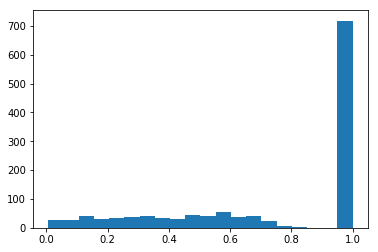

In [11]:
plt.hist(Genes['hg.pval'][~pd.isna(Genes.ratio)], bins=20);

(array([ 23.,  24.,  36.,  24.,  29.,  27.,  26.,  35.,  28.,  35.,  26.,
         21.,  35.,  41.,  22.,   6.,   2.,   1.,   0., 249.]),
 array([0.00677609, 0.05643729, 0.10609848, 0.15575968, 0.20542087,
        0.25508207, 0.30474326, 0.35440446, 0.40406565, 0.45372685,
        0.50338805, 0.55304924, 0.60271044, 0.65237163, 0.70203283,
        0.75169402, 0.80135522, 0.85101641, 0.90067761, 0.9503388 ,
        1.        ]),
 <a list of 20 Patch objects>)

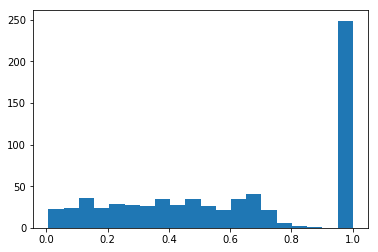

In [16]:
plt.hist(Genes['hg.pval'][~pd.isna(Genes.ratio) & Genes.Dn > 0], bins=20)

In [17]:
test = Genes.loc[~pd.isna(Genes.ratio) & Genes.Dn > 0, :].copy()

In [22]:
test.sort_values(['hg.pval'], ascending=True)

,Gene,Dn,Ds,Pn,Ps,ratio,hg.pval
251,1316408.3.peg.417,4.0,40.0,11.0,19.0,0.172727,0.006776
337,1316408.3.peg.525,4.0,2.0,3.0,23.0,15.333333,0.012174
886,1316408.3.peg.1140,2.0,2.0,1.0,47.0,47.000000,0.013213
2139,1316408.3.peg.240,3.0,2.0,6.0,59.0,14.750000,0.013346
1747,1316408.3.peg.2084,4.0,1.0,2.0,11.0,22.000000,0.021709
419,1316408.3.peg.607,4.0,1.0,2.0,11.0,22.000000,0.021709
57,1316408.3.peg.740,4.0,14.0,2.0,59.0,8.428571,0.022093
959,1316408.3.peg.1214,3.0,3.0,3.0,37.0,12.333333,0.022371
410,1316408.3.peg.598,6.0,10.0,11.0,77.0,4.200000,0.023009
178,1316408.3.peg.17,2.0,1.0,3.0,40.0,26.666667,0.027668


In [19]:
test.shape

(690, 7)

5.88235294117647

In [ ]:
%timeit np.matrix(site_crosstab)[:,::-1].diagonal()
%timeit np.fliplr(np.matrix(site_crosstab)).diagonal()